In [1]:
import gymnasium
import skyscraper
import numpy as np
from collections import defaultdict  # For initializing Q-values and other tables

import random
import time

env = gymnasium.make('skyscraper/GridWorld-v0')

In [2]:
env.reset()

({'agent': {'pos': array([13,  5])}}, {'distance': 49, 'steps': 0})

In [3]:
env.step(1)

c:\Users\shani\miniconda3\envs\gym\Lib\site-packages\gymnasium\utils\passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be int32, actual type: float64
  logger.warn(
c:\Users\shani\miniconda3\envs\gym\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


({'agent': {'pos': array([14.,  8.])}},
 0,
 False,
 False,
 {'distance': 46.0, 'steps': 1})

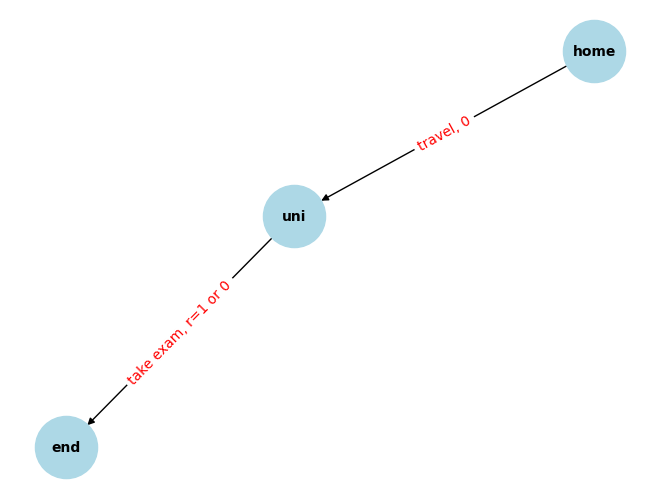

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a new directed graph
G = nx.DiGraph()

# Define the states and actions with rewards
states = ["home", "uni", "end"]
actions = {
    "home": [("uni", "travel", 0)],
    "uni": [("end", "take exam", "r=1 or 0")]
}

# Add nodes and edges with labels for each state and action
for state in states:
    G.add_node(state)

for source_state, action_list in actions.items():
    for target_state, action, reward in action_list:
        G.add_edge(source_state, target_state, label=f"{action}, {reward}")

# Position nodes using the spring layout
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold")

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.show()


## Env dynamics

In [5]:
powered_flight_data = open('powered_flight.txt', 'r')
powered_flight_data = powered_flight_data.read().split('\n')
len(powered_flight_data)
powered_flight_data


['18\t17\t1\t0\t17\t13',
 '4\t61\t1\t0\t4\t57',
 '12\t20\t2\t0\t11\t23',
 '17\t10\t2\t0\t19\t12',
 '8\t15\t1\t0\t9\t12',
 '3\t38\t1\t0\t3\t35',
 '18\t17\t2\t0\t17\t21',
 '5\t56\t1\t0\t5\t52',
 '4\t40\t2\t0\t2\t43',
 '3\t59\t2\t0\t3\t64',
 '3\t57\t2\t0\t4\t61',
 '2\t54\t1\t0\t3\t52',
 '10\t14\t2\t0\t11\t17',
 '19\t58\t2\t0\t21\t61',
 '2\t56\t1\t0\t2\t53',
 '8\t11\t2\t0\t8\t15',
 '4\t54\t2\t0\t3\t57',
 '11\t18\t1\t0\t12\t15',
 '6\t55\t1\t0\t5\t52',
 '6\t49\t1\t0\t4\t45',
 '4\t61\t2\t0\t5\t64',
 '3\t61\t1\t0\t3\t58',
 '7\t64\t2\t0\t9\t56',
 '10\t25\t1\t0\t9\t22',
 '1\t55\t2\t0\t2\t59',
 '4\t57\t2\t0\t4\t61',
 '2\t48\t2\t0\t2\t53',
 '7\t14\t2\t0\t7\t18',
 '4\t20\t2\t0\t3\t23',
 '12\t60\t2\t0\t15\t63',
 '9\t26\t1\t0\t8\t23',
 '14\t21\t2\t0\t12\t23',
 '22\t14\t1\t0\t23\t12',
 '4\t43\t2\t0\t3\t46',
 '5\t7\t2\t0\t6\t10',
 '2\t28\t2\t0\t4\t32',
 '2\t43\t1\t0\t3\t41',
 '2\t54\t2\t0\t3\t58',
 '8\t55\t2\t0\t6\t59',
 '11\t18\t2\t0\t12\t21',
 '16\t18\t2\t0\t15\t21',
 '14\t59\t2\t0\t15\t61',
 '13\t10

### First need to fix index problem, right know they are 1-indexed need to become 0-indexed bc env is 0-indexed.

In [6]:
def fix_index(powered_flight_data):
    fixed_data = []
    for line in powered_flight_data:
        data = line.strip().split('\t')
        print(data)
        if not data or len(data) != 6:
             continue
        
        try:
            print("here")
            adjusted_data = [int(value) - 1 if value else None for value in data]
            # print("adjusted1: ",adjusted_data)
            adjusted_data = [value for value in adjusted_data if value is not None]
            # print("adjusted2: ",adjusted_data)
            fixed_data.append(adjusted_data)
        except ValueError as e:
            print(f"Error processing line: {line} - {e}")
    return fixed_data
fixed_powered_flight_data = fix_index(powered_flight_data)
fixed_powered_flight_data


['18', '17', '1', '0', '17', '13']
here
['4', '61', '1', '0', '4', '57']
here
['12', '20', '2', '0', '11', '23']
here
['17', '10', '2', '0', '19', '12']
here
['8', '15', '1', '0', '9', '12']
here
['3', '38', '1', '0', '3', '35']
here
['18', '17', '2', '0', '17', '21']
here
['5', '56', '1', '0', '5', '52']
here
['4', '40', '2', '0', '2', '43']
here
['3', '59', '2', '0', '3', '64']
here
['3', '57', '2', '0', '4', '61']
here
['2', '54', '1', '0', '3', '52']
here
['10', '14', '2', '0', '11', '17']
here
['19', '58', '2', '0', '21', '61']
here
['2', '56', '1', '0', '2', '53']
here
['8', '11', '2', '0', '8', '15']
here
['4', '54', '2', '0', '3', '57']
here
['11', '18', '1', '0', '12', '15']
here
['6', '55', '1', '0', '5', '52']
here
['6', '49', '1', '0', '4', '45']
here
['4', '61', '2', '0', '5', '64']
here
['3', '61', '1', '0', '3', '58']
here
['7', '64', '2', '0', '9', '56']
here
['10', '25', '1', '0', '9', '22']
here
['1', '55', '2', '0', '2', '59']
here
['4', '57', '2', '0', '4', '61']
he

[[17, 16, 0, -1, 16, 12],
 [3, 60, 0, -1, 3, 56],
 [11, 19, 1, -1, 10, 22],
 [16, 9, 1, -1, 18, 11],
 [7, 14, 0, -1, 8, 11],
 [2, 37, 0, -1, 2, 34],
 [17, 16, 1, -1, 16, 20],
 [4, 55, 0, -1, 4, 51],
 [3, 39, 1, -1, 1, 42],
 [2, 58, 1, -1, 2, 63],
 [2, 56, 1, -1, 3, 60],
 [1, 53, 0, -1, 2, 51],
 [9, 13, 1, -1, 10, 16],
 [18, 57, 1, -1, 20, 60],
 [1, 55, 0, -1, 1, 52],
 [7, 10, 1, -1, 7, 14],
 [3, 53, 1, -1, 2, 56],
 [10, 17, 0, -1, 11, 14],
 [5, 54, 0, -1, 4, 51],
 [5, 48, 0, -1, 3, 44],
 [3, 60, 1, -1, 4, 63],
 [2, 60, 0, -1, 2, 57],
 [6, 63, 1, -1, 8, 55],
 [9, 24, 0, -1, 8, 21],
 [0, 54, 1, -1, 1, 58],
 [3, 56, 1, -1, 3, 60],
 [1, 47, 1, -1, 1, 52],
 [6, 13, 1, -1, 6, 17],
 [3, 19, 1, -1, 2, 22],
 [11, 59, 1, -1, 14, 62],
 [8, 25, 0, -1, 7, 22],
 [13, 20, 1, -1, 11, 22],
 [21, 13, 0, -1, 22, 11],
 [3, 42, 1, -1, 2, 45],
 [4, 6, 1, -1, 5, 9],
 [1, 27, 1, -1, 3, 31],
 [1, 42, 0, -1, 2, 40],
 [1, 53, 1, -1, 2, 57],
 [7, 54, 1, -1, 5, 58],
 [10, 17, 1, -1, 11, 20],
 [15, 17, 1, -1, 14, 2

In [7]:
print(len(fixed_powered_flight_data))
print(len(powered_flight_data))


909
910


In [8]:
a={1:1,2:3,4:5}

3 in a.values()

True

### Transtition function, reward function and model M:

In [9]:
transition_function = {}  # Transition function: (state, action) -> next state

for i, j, a, r, i_prime, j_prime in fixed_powered_flight_data:
    
    current_state = (i, j)
    next_state = (i_prime, j_prime)
    action = a
    
    transition_function[(current_state, action)] = next_state
transition_function

{((17, 16), 0): (16, 12),
 ((3, 60), 0): (3, 56),
 ((11, 19), 1): (10, 22),
 ((16, 9), 1): (18, 11),
 ((7, 14), 0): (8, 11),
 ((2, 37), 0): (2, 34),
 ((17, 16), 1): (16, 20),
 ((4, 55), 0): (4, 51),
 ((3, 39), 1): (1, 42),
 ((2, 58), 1): (2, 63),
 ((2, 56), 1): (3, 60),
 ((1, 53), 0): (2, 51),
 ((9, 13), 1): (10, 16),
 ((18, 57), 1): (20, 60),
 ((1, 55), 0): (1, 52),
 ((7, 10), 1): (7, 14),
 ((3, 53), 1): (2, 56),
 ((10, 17), 0): (11, 14),
 ((5, 54), 0): (4, 51),
 ((5, 48), 0): (3, 44),
 ((3, 60), 1): (4, 63),
 ((2, 60), 0): (2, 57),
 ((6, 63), 1): (8, 55),
 ((9, 24), 0): (8, 21),
 ((0, 54), 1): (1, 58),
 ((3, 56), 1): (3, 60),
 ((1, 47), 1): (1, 52),
 ((6, 13), 1): (6, 17),
 ((3, 19), 1): (2, 22),
 ((11, 59), 1): (14, 62),
 ((8, 25), 0): (7, 22),
 ((13, 20), 1): (11, 22),
 ((21, 13), 0): (22, 11),
 ((3, 42), 1): (2, 45),
 ((4, 6), 1): (5, 9),
 ((1, 27), 1): (3, 31),
 ((1, 42), 0): (2, 40),
 ((1, 53), 1): (2, 57),
 ((7, 54), 1): (5, 58),
 ((10, 17), 1): (11, 20),
 ((15, 17), 1): (14, 2

In [10]:
reward_function = {}  # Reward function: (state, action, next state) -> reward

for i, j, a, r, i_prime, j_prime in fixed_powered_flight_data:
    current_state = (i, j)
    next_state = (i_prime, j_prime)
    action = a
    
    reward_function[(current_state, action)] = r
    
    
reward_function


{((17, 16), 0): -1,
 ((3, 60), 0): -1,
 ((11, 19), 1): -1,
 ((16, 9), 1): -1,
 ((7, 14), 0): -1,
 ((2, 37), 0): -1,
 ((17, 16), 1): -1,
 ((4, 55), 0): -1,
 ((3, 39), 1): -1,
 ((2, 58), 1): -1,
 ((2, 56), 1): -1,
 ((1, 53), 0): -1,
 ((9, 13), 1): -1,
 ((18, 57), 1): -1,
 ((1, 55), 0): -1,
 ((7, 10), 1): -1,
 ((3, 53), 1): -1,
 ((10, 17), 0): -1,
 ((5, 54), 0): -1,
 ((5, 48), 0): -1,
 ((3, 60), 1): -1,
 ((2, 60), 0): -1,
 ((6, 63), 1): -1,
 ((9, 24), 0): -1,
 ((0, 54), 1): -1,
 ((3, 56), 1): -1,
 ((1, 47), 1): -1,
 ((6, 13), 1): -1,
 ((3, 19), 1): -1,
 ((11, 59), 1): -1,
 ((8, 25), 0): -1,
 ((13, 20), 1): -1,
 ((21, 13), 0): -1,
 ((3, 42), 1): -1,
 ((4, 6), 1): -1,
 ((1, 27), 1): -1,
 ((1, 42), 0): -1,
 ((1, 53), 1): -1,
 ((7, 54), 1): -1,
 ((10, 17), 1): -1,
 ((15, 17), 1): -1,
 ((13, 58), 1): -1,
 ((12, 9), 1): -1,
 ((13, 5), 1): -1,
 ((5, 55), 1): -1,
 ((6, 57), 1): -1,
 ((16, 12), 1): -1,
 ((4, 25), 1): -1,
 ((1, 13), 1): -1,
 ((3, 22), 1): -1,
 ((5, 62), 0): -1,
 ((9, 18), 1): -1,
 

In [11]:
def model_M(current_state, action, transition_function, reward_function):
    """
    Simulate the environment's response to an action taken in a state.

    Parameters:
    - state: The current state (i, j).
    - action: The action taken in the current state.
    - T: The transition function mapping (current_state, action) pairs to next states.
    - R: The reward function mapping (current_state, action, next_state) triplets to rewards.

    Returns:
    - next_state: The state resulting from taking the action in the current state.
    - reward: The immediate reward received for this transition.
    """
    next_state = transition_function.get((current_state, action), None)  # Get the next state from T
    # print("next_state: ",next_state)
    reward = reward_function.get((current_state, action), 0)  # Get the reward from R
    # print("reward: ",reward)
    
    return next_state, reward
print(model_M((12, 17), 0, transition_function, reward_function))


((12, 13), -1)


## Dyna arcitecture:

In [12]:
action_space = [0, 1]  
alpha = 0.5
gamma = 0.99
epsilon = 0.3
n_planning_steps = 100
punishment=0.01
T = 1000  # Total number of real interactions
state = env.reset()[0]['agent']['pos']
state = tuple(state)


# Initialize Q-values
# Q = defaultdict(lambda: np.zeros(env.action_space.n))
Q=np.zeros((env.height,env.width,env.action_space.n))

# def state_to_key(state):
#     if isinstance(state, dict):
        
#         pos_array = state['agent']['pos']
#     elif isinstance(state, tuple) and isinstance(state[0], dict):
       
#         pos_array = state[0]['agent']['pos']
#     else:
    
#         pos_array = state
#     return tuple(pos_array)




c:\Users\shani\miniconda3\envs\gym\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(
c:\Users\shani\miniconda3\envs\gym\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(


In [13]:
# Choose action based on ε-greedy policy
def choose_action(state, Q, epsilon):
    if random.random() < epsilon:
        # print("random")
        return env.action_space.sample()  
    else:
        # print("greedy")
        # state = state  
        return np.argmax(Q[state])  

# Direct learning from real experience
def q_learning_update(Q, state, action, reward, next_state, alpha, gamma):
    # state_key = state_to_key(state)
    # next_state_key = state_to_key(next_state)
    # print('next_state: ',(next_state))
    # next_state=tuple(map(int,next_state))
    # print('q, next',Q[next_state][:])
    best_next_action = np.argmax(Q[next_state])
    # print("best_next_action: ",best_next_action)
    # print("best_next_action: ",best_next_action)
    td_target = reward + gamma * Q[next_state][best_next_action]
    td_error = td_target - Q[state][action]
    Q[state][action] += alpha * td_error
    
    


In [14]:
# map(int((1.0,2.0))

In [15]:
def print_optimal_policy(Q):
   return np.argmax(Q,axis=2)
        # print(f"Optimal action for state {state} is {optimal_action}")

print_optimal_policy(Q)


# Main loop for Dyna-Q

for k in range(T):
    # epsilon = epsilon * 0.99
    # print(k)
    if k % 100 == 0:
        print(f"Real interaction {k}/{T}")
    
    state =env.reset()[0]['agent']['pos']
    state = tuple(state)
    start_state=state
    # print("state: ",state)  
    done = False
    steps = 0
    counter=0
    done = False
    while not done:
        counter+=1
        # print(counter)
        # state_key = state_to_key(state)
        action = choose_action(state, Q, epsilon)
        # print("action: ",action)
        next_state, reward, done, err, info = env.step(action) 
        # print('err', err)
        # print("next state 1", next_state)
        # next_state = tuple(next_state)
        next_state = tuple(map(int,next_state['agent']['pos']))
        # print("next_state: ",next_state)
        
        # next_state_key = state_to_key(next_state)  
        q_learning_update(Q, state, action, reward, next_state, alpha, gamma)
        transition_function[(state, action)] = next_state
        reward_function[(state, action)] = reward
        if done or (start_state==next_state and state != start_state) or (counter==1 and next_state==start_state):
            Q[state][action]-= punishment
            break
        state = next_state
        # print("state", state)
        
        
        
    # print('after')
    for m in range(n_planning_steps):
        # print("m: ",m)
        sampled_state, sampled_action = random.choice(list(transition_function.keys()))
        #sampled_action = random.choice(action_space)
        if (sampled_state, sampled_action) in transition_function:
            # simulated_next_state, simulated_reward = model_M(sampled_state, sampled_action, transition_function, reward_function)
            simulated_next_state = transition_function[(sampled_state, sampled_action)]
            simulated_reward = reward_function[(sampled_state, sampled_action)]
            q_learning_update(Q, sampled_state, sampled_action, simulated_reward, simulated_next_state, alpha, gamma)
            # print('hi')
            
            # else:
            #     print(f"Transition for state {sampled_state} and action {sampled_action} not found.")

        
        state = next_state 
        steps += 1

    # print(f"Episode {episode+1}/{T} completed in {steps} steps. Total Time: {time.time() - start_time:.2f} seconds.")


# env.close()
policy=print_optimal_policy(Q)
policy


Real interaction 0/1000
Real interaction 100/1000
Real interaction 200/1000


Real interaction 300/1000
Real interaction 400/1000
Real interaction 500/1000
Real interaction 600/1000
Real interaction 700/1000
Real interaction 800/1000
Real interaction 900/1000


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [16]:
policy = np.argmax(Q,axis=2)
policy[start_state]

1

In [17]:
# Assuming other parts of your code remain unchanged
def run_with_policy(env, policy_matrix, num_steps=1000):
    observation, _ = env.reset()
    # Convert observation to initial position tuple
    current_pos = tuple(map(int, observation["agent"]["pos"]))

    for step in range(num_steps):
        if step % 10 == 0:
            print(f"Steps: {step} to {step + 99} of {num_steps}")

        # env.render()

        # Directly use current_pos to get the best action from the policy matrix
        action = policy_matrix[current_pos]
        print("action: ",action)
        #print(f"Action: {action}")

        # Take the action in the environment
        observation, reward, done, _, _ = env.step(action)

        # Update current position based on the observation
        current_pos = tuple(map(int, observation["agent"]["pos"]))
        
        print(f"Current Position: {current_pos}")

        if done:
            #print("Reached the goal or crashed, resetting.")
            observation, _ = env.reset()
            current_pos = tuple(map(int, observation["agent"]["pos"]))

    # env.close()

env = gymnasium.make('skyscraper/GridWorld-v0',render_mode="human")
print("Run with policy")
run_with_policy(env, policy)
# env.close()

Run with policy
Steps: 0 to 99 of 1000
action:  1


c:\Users\shani\miniconda3\envs\gym\Lib\site-packages\gymnasium\utils\passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be int32, actual type: float64
  logger.warn(
c:\Users\shani\miniconda3\envs\gym\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Current Position: (14, 8)
action:  1
Current Position: (15, 11)
action:  1
Current Position: (17, 13)
action:  1
Current Position: (18, 16)
action:  1
Current Position: (18, 19)
action:  1
Current Position: (16, 22)
action:  0
Current Position: (14, 19)
action:  0
Current Position: (12, 15)
action:  0
Current Position: (12, 11)
action:  1
Current Position: (14, 13)
Steps: 10 to 109 of 1000
action:  0
Current Position: (15, 9)
action:  1
Current Position: (17, 11)
action:  0
Current Position: (19, 8)
action:  1
Current Position: (20, 11)
action:  1
Current Position: (22, 15)
action:  1
Current Position: (22, 19)
action:  0
Current Position: (20, 17)
action:  0
Current Position: (20, 15)
action:  1
Current Position: (20, 19)
action:  0
Current Position: (18, 17)
Steps: 20 to 119 of 1000
action:  0
Current Position: (18, 14)
action:  0
Current Position: (19, 11)
action:  1
Current Position: (21, 15)
action:  0
Current Position: (21, 13)
action:  1
Current Position: (22, 17)
action:  0
Cur

KeyboardInterrupt: 

In [ ]:
env.close()

In [ ]:
Q

array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [-5.85198506, -6.79346521],
        [ 0.        , -2.9701    ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [-3.940399  , -6.79346521],
        [-3.940399  , -6.79346521],
        [-3.940399  , -6.79346521]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [-4.90099501, -6.79346521],
        [-3.940399  , -6.79346521],
        [-3.940399  , -2.9701    ]],

       ...,

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.  

## Model development

<!-- power flight.txt in the format (i, j, a, r, i′.j′), where
(i, j) is the current state, a the action, r the reward, and (i′, j′) the next state. -->

In [ ]:
# def make_state_representations(fixed_powered_flight_data):
#     state_representation = {}
#     for data in fixed_powered_flight_data:
       
#         if not data or len(data) != 6:
#             continue
        
#         try:
#             i, j, a, r, i_prime, j_prime = map(int, data)  
            
#             a_new = -3 if a == 1 else 3
            
#             current_state = (i, j)
#             # print("current_state",current_state)
#             action = a_new
#             # print("action",action)
#             reward = r
#             # print("reward",reward)
#             next_state = (i_prime, j_prime)
#             # print("next_state",next_state)
            
#             if current_state not in state_representation:
#                 state_representation[current_state] = {
#                     'actions': {}, 
#                     'transitions': [],  
#                     'reward': 0  
#                 }
            
#             state_representation[current_state]['actions'][action] = next_state
            
#             if reward > state_representation[current_state]['reward']:
#                 state_representation[current_state]['reward'] = reward
                
#             state_representation[current_state]['transitions'].append((action, next_state, reward))
#             # print("state_representation",state_representation['transitions'])
            
#         except ValueError:
#             print(f"Error processing line: {data}")

#     return state_representation

# state_representation = make_state_representations(fixed_powered_flight_data)



In [ ]:
# state_representation[(6, 40)]

In [ ]:
        # def transtition_function